In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import nutpie
import arviz as az
import pytensor.tensor as at
import matplotlib.pyplot as plt
from util import build_XY

In [2]:
# set the seed
np.random.seed(123)

In [3]:
df = pd.read_csv("../data/interest_rates.csv")
df.shape

(255, 3)

In [4]:
df.columns

Index(['date', 'rate', 'country'], dtype='object')

In [5]:
df.head()

,date,rate,country
0,2016-01-01,0.34,US
1,2016-02-01,0.38,US
2,2016-03-01,0.36,US
3,2016-04-01,0.37,US
4,2016-05-01,0.37,US


In [6]:
df.isna().sum()

date       0
rate       0
country    0
dtype: int64

In [7]:
df.describe()

,rate
count,255.000000
mean,0.922902
std,0.849901
min,0.050000
25%,0.250000
50%,0.750000
75%,1.500000
max,4.330000


In [8]:
adf = df
adf["date"] = pd.to_datetime(adf["date"])

In [9]:
# # Standardise output
# adf["rate"] = (adf["rate"] - adf["rate"].mean())/adf["rate"].std()
# adf["rate"].describe()

In [10]:
adf["country"].unique()

array(['US', 'UK', 'AU'], dtype=object)

In [11]:
adf.shape

(255, 3)

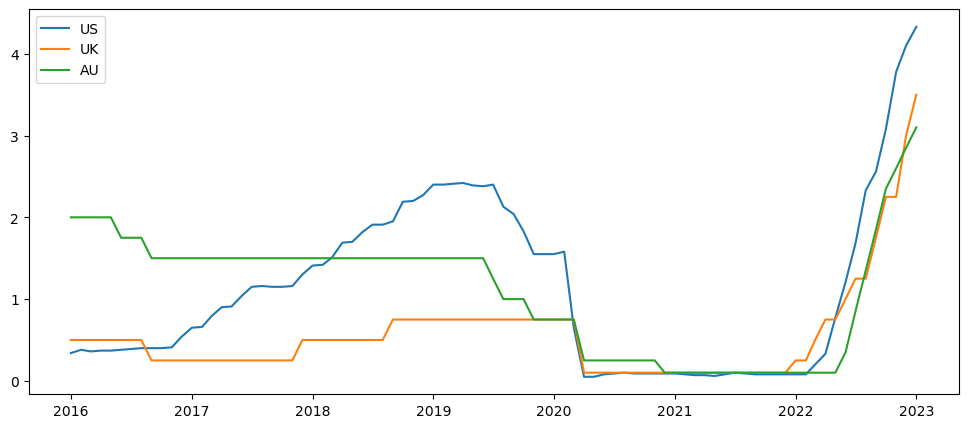

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
legends = []
for country in ['US', 'UK', 'AU']:
    cond = adf["country"] == country
    ax.plot(adf.loc[cond, "date"], adf.loc[cond, "rate"])
    legends.append(country)
plt.legend(legends)

### Create training data

In [13]:
dates_idx = pd.DataFrame({"date":pd.date_range(adf["date"].min(), adf["date"].max(), freq='MS')}).reset_index()
dates_idx = dates_idx.rename(columns={"index":"x"})
print(dates_idx.shape)
dates_idx.head()

(85, 2)


,x,date
0,0,2016-01-01
1,1,2016-02-01
2,2,2016-03-01
3,3,2016-04-01
4,4,2016-05-01


In [15]:
dates_idx.tail()

,x,date
80,80,2022-09-01
81,81,2022-10-01
82,82,2022-11-01
83,83,2022-12-01
84,84,2023-01-01


In [18]:
adf = adf.merge(dates_idx, how="left", on="date")
adf = adf.dropna()
adf

,date,rate,country,x
0,2016-01-01,0.34,US,0
1,2016-02-01,0.38,US,1
2,2016-03-01,0.36,US,2
3,2016-04-01,0.37,US,3
4,2016-05-01,0.37,US,4
...,...,...,...,...
250,2022-09-01,1.85,AU,80
251,2022-10-01,2.35,AU,81
252,2022-11-01,2.60,AU,82
253,2022-12-01,2.85,AU,83


In [19]:
country_mapping = {"US":0, "UK":1, "AU":2} 
adf["output_idx"] = adf["country"].map(country_mapping)
adf

,date,rate,country,x,output_idx
0,2016-01-01,0.34,US,0,0
1,2016-02-01,0.38,US,1,0
2,2016-03-01,0.36,US,2,0
3,2016-04-01,0.37,US,3,0
4,2016-05-01,0.37,US,4,0
...,...,...,...,...,...
250,2022-09-01,1.85,AU,80,2
251,2022-10-01,2.35,AU,81,2
252,2022-11-01,2.60,AU,82,2
253,2022-12-01,2.85,AU,83,2


In [20]:
adf = adf.sort_values(["output_idx", "x"])
X = adf[["x", "output_idx"]].values
Y = adf["rate"].values
X.shape, Y.shape

((255, 2), (255,))

### GP model with ICM

In [34]:
def get_icm(input_dim, kernel, W=None, kappa=None, B=None, active_dims=None, name='ICM'):
    coreg = pm.gp.cov.Coregion(input_dim=input_dim, W=W, kappa=kappa, B=B, active_dims=active_dims)
    icm_cov = kernel * coreg # Seperate input => Use Hadamard Product
    return icm_cov

In [35]:
n_outputs = 3

In [38]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    kernel = pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Get ICM kernel
    W = pm.Normal("W", mu=0, sigma=3, shape=(n_outputs,2), initval=np.random.randn(n_outputs,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=n_outputs)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa))
    
    cov_icm = get_icm(input_dim=2, kernel=kernel, B=B, active_dims=[1])

    # Define a Multi-output GP 
    mogp = pm.gp.Marginal(cov_func=cov_icm)
    y_ = mogp.marginal_likelihood("f", X, Y, sigma=sigma)   

In [39]:
%%time
with model:
    gp_trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, W, kappa]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 923 seconds.


CPU times: user 1h 16min 37s, sys: 46min 9s, total: 2h 2min 46s
Wall time: 15min 26s


/home/danh/miniconda3/envs/creditrisk/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [40]:
%%time
# Sampling with nutpie
compiled_model = nutpie.compile_pymc_model(model)
trace_nutpie = nutpie.sample(compiled_model, draws=1000, chains=1)

/home/danh/miniconda3/envs/creditrisk/lib/python3.9/site-packages/pymc/util.py:501: FutureWarning: The tag attribute observations is deprecated. Use model.rvs_to_values[rv] instead
  warnings.warn(
/home/danh/miniconda3/envs/creditrisk/lib/python3.9/site-packages/pytensor/link/numba/dispatch/basic.py:355: UserWarning: Numba will use object mode to run AdvancedSubtensor's perform method
  warnings.warn(
/home/danh/miniconda3/envs/creditrisk/lib/python3.9/site-packages/pytensor/link/numba/dispatch/basic.py:355: UserWarning: Numba will use object mode to run SolveTriangular{lower=True, trans=0, unit_diagonal=False, check_finite=True}'s perform method
  warnings.warn(
/home/danh/miniconda3/envs/creditrisk/lib/python3.9/site-packages/pytensor/link/numba/dispatch/basic.py:355: UserWarning: Numba will use object mode to run SolveTriangular{lower=False, trans=0, unit_diagonal=False, check_finite=True}'s perform method
  warnings.warn(
/home/danh/miniconda3/envs/creditrisk/lib/python3.9/site-pa

CPU times: user 11min 56s, sys: 21min 30s, total: 33min 27s
Wall time: 4min 35s


In [41]:
X.shape, Y.shape, 243/3

((255, 2), (255,), 81.0)

## Prediction

In [55]:
M = dates_idx.shape[0] + 6 # Predict for next 6 months
x_new = np.linspace(0, M, M)[:, None]
X_new, _, _ = build_XY([x_new for idx in range(n_outputs)])
X_new.shape, M

((273, 2), 91)

In [43]:
# %%time
# with model:
#     preds = mogp.conditional("preds", X_new)
#     gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

In [44]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(trace_nutpie, var_names=['preds'], random_seed=42)

Sampling: [preds]


CPU times: user 3min 4s, sys: 1min 30s, total: 4min 34s
Wall time: 34.9 s


In [54]:
gp_samples.to_netcdf("./mogp.nc")

'./mogp.nc'

In [45]:
# pm.model_to_graphviz(model)

In [46]:
country_mapping = {"US":0, "UK":1, "AU":2} 

In [47]:
country_mapping.keys()

dict_keys(['US', 'UK', 'AU'])

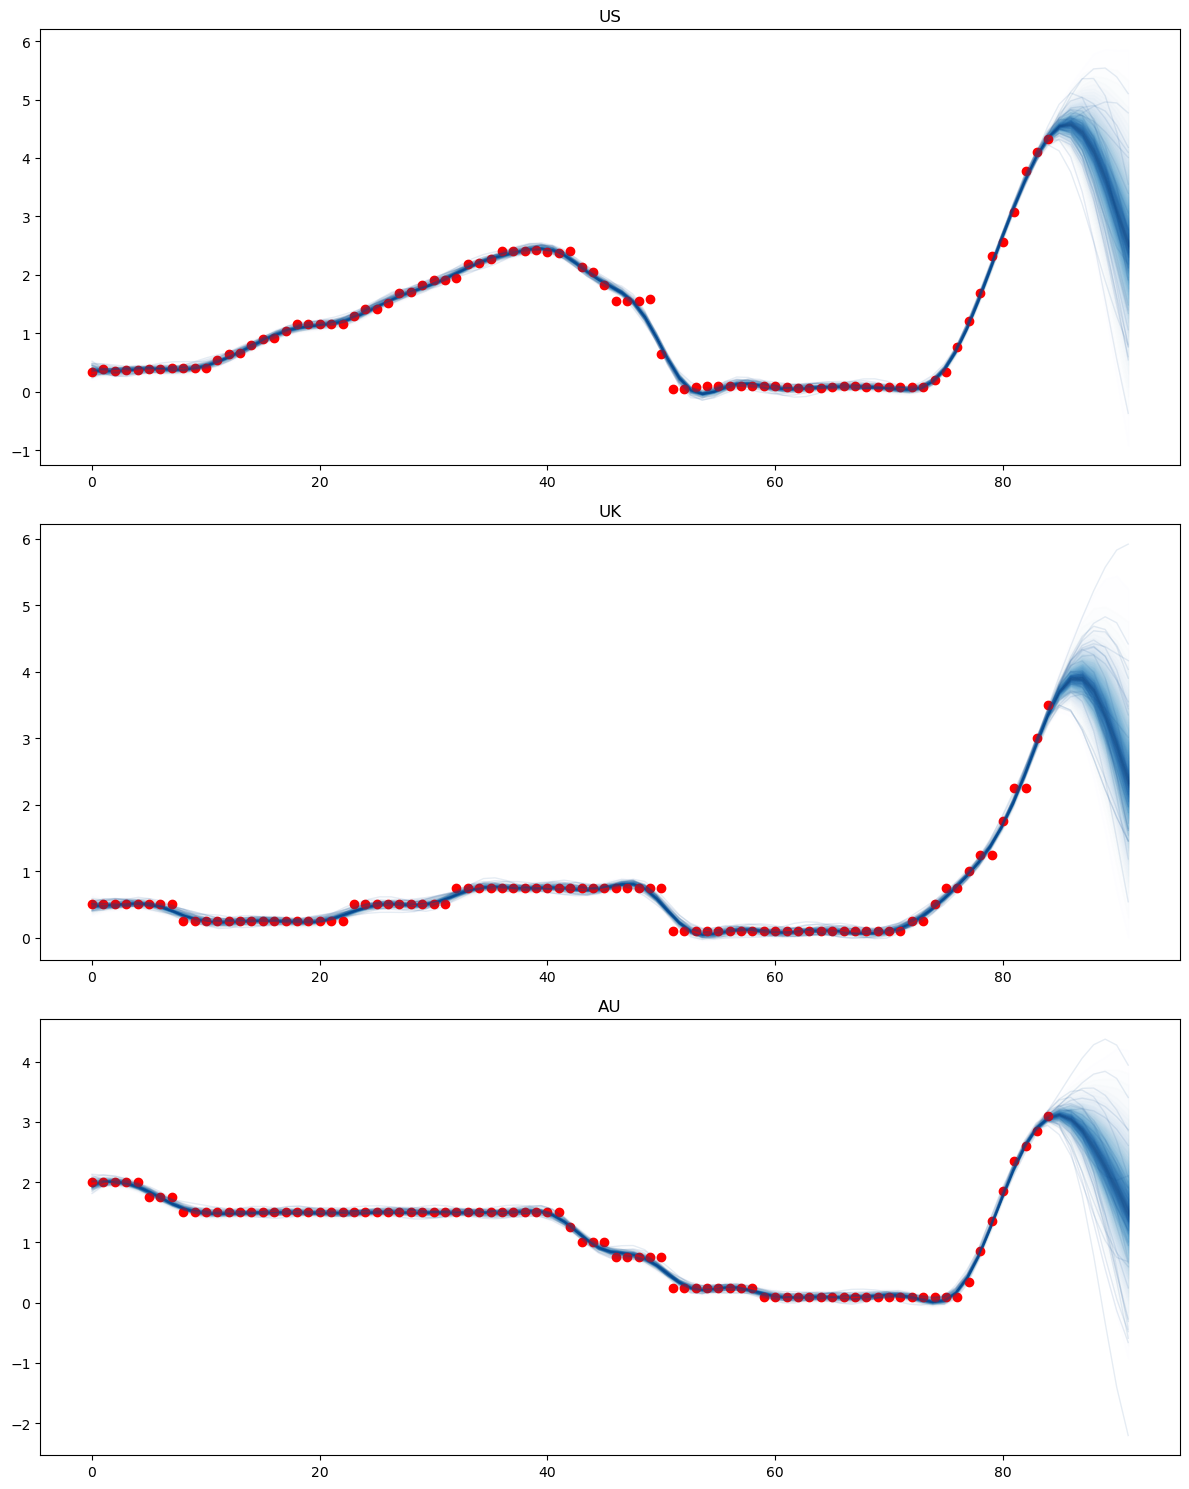

In [48]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(n_outputs,1, figsize=(12,15))

for idx, country in enumerate(country_mapping.keys()):
    # Prediction
    plot_gp_dist(axes[idx], f_pred[:,M*idx:M*(idx+1)], 
                 X_new[M*idx:M*(idx+1),0], 
                 palette="Blues", fill_alpha=0.1, samples_alpha=0.1)    
    # Train data points
    cond = adf["country"] == country
    axes[idx].scatter(adf.loc[cond, "x"], adf.loc[cond, "rate"], color='r')
    axes[idx].set_title(country)
plt.tight_layout()